# **CIS 520: Machine Learning**

## **Movie Recommender System**


- **Content Creator:** Mohitrajhu Lingan Kumaraian
- **Content Reviewers:** Siyun Hu, Yijie Lu, Rohan Chhaya
- **Reference:** 
  - https://heartbeat.fritz.ai/recommender-systems-with-python-part-ii-collaborative-filtering-k-nearest-neighbors-algorithm-c8dcd5fd89b2



- **Objectives:** In this worksheet, we will see how to build a simple KNN based Recommender System that recommends movies based on the users' watch history.







# Initialize Penn Grader

In [1]:
%%capture
!pip install penngrader

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os 

In [3]:
# For autograder only, do not modify this cell. 
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")
    sys.exit()

[INFO, OK] Google Colab.


In [4]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 57931095 # YOUR PENN-ID GOES HERE AS AN INTEGER#

In [5]:
import penngrader.grader

grader = penngrader.grader.PennGrader(homework_id = 'CIS_5200_202230_HW_Recommender_System_WS', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 57931095

Make sure this correct or we will not be able to store your grade


In [6]:
# A helper function for grading utils
def grader_serialize(obj):        # A helper function
    '''Dill serializes Python object into a UTF-8 string'''
    byte_serialized = dill.dumps(obj, recurse = True)
    return base64.b64encode(byte_serialized).decode("utf-8")

## **Short Background**

Many internet services such as Youtube, Netflix, Spotify are Recommender Systems. Recommender Systems can be divided into three categories: Content-Filtering, Collaborative Filtering and Hybrid --a combination of the other two systems .

**Content Filtering**  uses features of an item to recommend  similar items to users. It is used when a new user joins the platform as we don't know anything about the user's taste and behavioral pattern.

**Collaborative Filtering** uses a user's past behaviour--its similarity with other others--to recommend similar products to the user. It works on the idea that people who have had similar behaviors in the past will behave similarly in the future, i.e if two users have liked similar items in the past then they would also agree we can recommend items from one of the user's list of purchased/viewed items to another user who hasn't.


In this worksheet, we will do collaborative filtering: recommend similar movies to the users who have given high ratings to similar movies.

In [7]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
downloaded = drive.CreateFile({'id':"1h5fvp9dQcqPqh-VC_mWrZD5m26YIj03l"})   # replace the id with id of file you want to access
downloaded.GetContentFile('movies.csv')   

## **Data Preparation**
We will use the Movielens dataset, which contains a set of movies and the ratings given to these movies by different users. Specifically, we use:

  * movies.csv, which contains movies with their corresponding ids
  * ratings.csv, which contains user ratings of the movies.


The general idea of this task is:
  1. We will cluster movies by user rating similarity
  2. Recommend movies to the users who have given high ratings to similar movie before


In [9]:
import pandas as pd
movies = pd.read_csv('movies.csv',usecols=['movie_id','movie'],encoding='unicode_escape')
movies = movies.reset_index()
print('Number of Movies:'+str(len(movies)))
movies.head(10)

Number of Movies:3883


,index,movie_id,movie
0,0,1,Toy Story (1995)
1,1,2,Jumanji (1995)
2,2,3,Grumpier Old Men (1995)
3,3,4,Waiting to Exhale (1995)
4,4,5,Father of the Bride Part II (1995)
5,5,6,Heat (1995)
6,6,7,Sabrina (1995)
7,7,8,Tom and Huck (1995)
8,8,9,Sudden Death (1995)
9,9,10,GoldenEye (1995)


In [10]:
downloaded = drive.CreateFile({'id':"1HGvJF2WIkhfqbgTLQYIMqR0e9_eimuqz"})
downloaded.GetContentFile("ratings.csv")

In [11]:
ratings_df = pd.read_csv('ratings.csv',index_col=False,usecols=['user_id','movie_id','rating'],dtype={'userId':'int32','movieId':'int32','rating':'float32'})
print('number of users:'+str(ratings_df['user_id'].nunique()))
print('number of user rating:'+str(len(ratings_df)))

number of users:6040
number of user rating:1000209


In [12]:
ratings_df.head(10)

,user_id,movie_id,rating
0,1,1193,5.0
1,1,661,3.0
2,1,914,3.0
3,1,3408,4.0
4,1,2355,5.0
5,1,1197,3.0
6,1,1287,5.0
7,1,2804,5.0
8,1,594,4.0
9,1,919,4.0


# Question 1


The rating matrix is sparse, which can be found by $\frac{num\_rating}{num\_users * num\_movies}$ and represents the proportion of non-zero entries. Find this value and submit it as a decimal rounded to the nearest hundredth.

In [13]:
import numpy as np
sparse = np.round(len(ratings_df)/(ratings_df['user_id'].nunique() * len(movies)), 2)
grader.grade(test_case_id='test_sparse', answer=sparse)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [14]:
from scipy.sparse import csr_matrix

# create pivot table 
# row - movie; column - user
movie_features = ratings_df.pivot(index='movie_id',columns='user_id',values='rating').fillna(0)
movie_features

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e113cfa10>]],
      dtype=object)

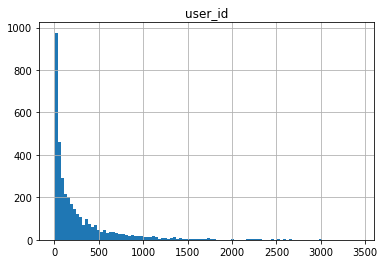

In [15]:
rating_num = ratings_df.groupby(by='movie_id').count().reset_index()
rating_num.hist(column='user_id',bins=100)

As you see, the data  is  sparse.  To make the problem simpler, we remove users who have rated fewer than 50 movies and movies that have been rated by fewer than 50 users.  (Amazon, of course, doesn't have this luxury.)

In [16]:
##Threshold to distinguish active user
user_thresh = 50
user_cnt = ratings_df.groupby(by='user_id').count().reset_index()
active_users = list(set(user_cnt.query('movie_id>=@user_thresh').index))
print("Number of active users: "+str(len(active_users)))
ratings_df_activeusers = ratings_df[ratings_df.user_id.isin(active_users)]
print("Length of rating dataframe after dropping inactive users: "+str(len(ratings_df_activeusers)))
## Threshold of number of user ratings to eliminate a movie
movie_pop_thresh = 50
movie_cnt = ratings_df_activeusers.groupby(by='movie_id').count().reset_index()
popular_movies = list(set(movie_cnt.query('user_id >= @movie_pop_thresh').index))
curated_ratings_df = ratings_df_activeusers[ratings_df_activeusers.movie_id.isin(popular_movies)]
print("Number of popular Movies above the set threshold: "+str(len(popular_movies)))
print('Length of final curated ratings dataframe: '+str(len(curated_ratings_df)))

Number of active users: 4297
Length of rating dataframe after dropping inactive users: 718941
Number of popular Movies above the set threshold: 2289
Length of final curated ratings dataframe: 427434


In [17]:
curated_ratings_df

,user_id,movie_id,rating
2,1,914,3.0
3,1,3408,4.0
4,1,2355,5.0
6,1,1287,5.0
7,1,2804,5.0
...,...,...,...
999863,6039,1081,4.0
999864,6039,1083,3.0
999865,6039,1086,4.0
999866,6039,1088,4.0


In [18]:
movie_features = curated_ratings_df.pivot(index='movie_id',columns='user_id',values='rating').fillna(0)
movie_features 

user_id,1,2,4,5,7,8,9,10,12,14,...,6025,6029,6030,6031,6032,6034,6035,6036,6038,6039
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,5.0,5.0,0.0,0.0,...,5.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# compress sparse row matrix
movie_features_mat = csr_matrix(movie_features.values)

## **Building Model**

We will now build a simple KNN based Recommender System. The KNN model doesn't make any assumptions about the underlying data distribution. It simply calculates the similarity between the target movie and other movies in the database and ranks them in from most to least similar. 

We use Cosine similarity to measure the similarity (the normalized dot prodict) between any two movies, where each movie is represented as a vector of the people who have watched it:


<img src="https://drive.google.com/uc?id=1YcK3uWVMZjEvCFNg2U8FEOQ-ttmPKsn_">



## Question 2

Here, we use cosine similarity to measure the similarity between movies. However, there are alternative measures we can use. For example,  Euclidian distance is one of the most common distance functions. Do you think it is a good idea to use Euclidian distance here? What is 1 metric that Euclidean distance inherently measures that would be problematic here? 
(Hint: 1 word, related to vectors)


In [31]:
cosine_better = "magnitude"
grader.grade(test_case_id='test_cosine_similarity', answer=cosine_better)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### Fit the model

In [21]:
!pip install fuzzywuzzy
from fuzzywuzzy import process

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Question 3
Fit the model using sklearn.neighbors and the NearestNeighbors package

In [22]:
from sklearn.neighbors import NearestNeighbors

#TODO: Build a model using the NearestNeighbors initializer from documentation.
# Use a cosine similarity metric, a brute-force algorithm, and 18 nearest neighbors
recommender_knn = NearestNeighbors(n_neighbors = 18, algorithm = 'brute', metric = 'cosine')

# fit the model (do not modify this)
recommender_knn.fit(movie_features_mat)
valid_params = recommender_knn.metric + "," + recommender_knn.algorithm + "," + str(recommender_knn.n_neighbors)
grader.grade(test_case_id='test_recommender_model', answer=valid_params)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [23]:
movie_features_set = movie_features.reset_index()
movie_idx = list(set(movie_features_set['movie_id']))
## generate a hash map of movie names with their movie_id
hash_map = {list(movies.loc[movies['movie_id']==movie_id]['movie'])[0]:idx for idx,movie_id in enumerate(movie_idx)}
keys = list(hash_map.keys())
#20 of the most recent movies in our matrix
keys.sort(key=lambda x: int(x[x.rindex("(")+1] + x[x.rindex("(")+2] + x[x.rindex("(")+3] + x[x.rindex("(")+4]), reverse=True)
keys[:20]

['Gun Shy (2000)',
 'Beach, The (2000)',
 'Snow Day (2000)',
 'Hanging Up (2000)',
 'Whole Nine Yards, The (2000)',
 'Wonder Boys (2000)',
 '3 Strikes (2000)',
 'Chain of Fools (2000)',
 'Drowning Mona (2000)',
 'Beyond the Mat (2000)',
 'Closer You Get, The (2000)',
 'Mission to Mars (2000)',
 'Erin Brockovich (2000)',
 'Romeo Must Die (2000)',
 'Here on Earth (2000)',
 'High Fidelity (2000)',
 'Price of Glory (2000)',
 'Road to El Dorado, The (2000)',
 'Frequency (2000)',
 'Return to Me (2000)']

### Make recommendations
Enter your favorite movie (make sure it is in the list) and see what movies the system recommends. How well does it work? Any patterns to when it  is better or worse? Note you need the year in your movie name, but fuzzy string matching allows for some natural discrepencies in the titles

Testing whether a movie exists in the set can be done with a simple 

`print("movie_name (YYYY)" in hash_map)`


Note: This is a very basic recommendation system with a small data set so its performance is not as good as the one Netflix uses.

In [24]:
import time
##Enter Favorite movie here
fav_movie = 'Tom & Viv (1994)'
## number of movies that you want the recommender system to recommend
num_recommendations = 10

# record the time we use to make recommendations
start = time.time()

print('Recommendation in process')
# extract the movie id of the given favorite movie
idx = hash_map[process.extractOne(fav_movie,list(hash_map.keys()))[0]]
# get the top 10 nearest neighbors of the given favorite movie
similarity,idxs = recommender_knn.kneighbors(movie_features_mat[idx],n_neighbors=num_recommendations+1)
# sort by similarity (descending)
idx_recommends = sorted(list(zip(similarity.squeeze().tolist(),idxs.squeeze().tolist())),key=lambda x:x[0])[:0:-1]
# swap key and value of hash map
rev_map = {idx:movie for movie,idx in hash_map.items()}
# print out the recommendation result
print('Recommendations for movies similar to {}'.format(fav_movie))
for i,(similarity,idx) in enumerate(idx_recommends):
  print('{0}:{1} with a similarity of {2}'.format(i+1,rev_map[idx],similarity))

print('time taken:{}'.format(time.time()-start))

Recommendation in process
Recommendations for movies similar to Tom & Viv (1994)
1:Fall Time (1995) with a similarity of 0.7635668516159058
2:Number Seventeen (1932) with a similarity of 0.7635668516159058
3:Born to Win (1971) with a similarity of 0.7635668516159058
4:Big Trees, The (1952) with a similarity of 0.7635668516159058
5:Grass Harp, The (1995) with a similarity of 0.7591631412506104
6:Cü¾¼rü¾¼monie, La (1995) with a similarity of 0.7564256191253662
7:Dancing at Lughnasa (1998) with a similarity of 0.7463877201080322
8:Mrs. Parker and the Vicious Circle (1994) with a similarity of 0.7420079708099365
9:Feast of July (1995) with a similarity of 0.6995357275009155
10:Run of the Country, The (1995) with a similarity of 0.6689935922622681
time taken:1.383404016494751


# Question 4

Play around with the system! Try different movies, different genres, and numbers of recommendations! Note that because of fuzzy string matching, you don't have to get the titles 100% correct when inputting above

Report the    
A) Movie with the highest similarity to Tom & Viv (coded as "Tom & Viv (1994)") (**NOTE**: Use a list of 10 recommendations here as changing this number creates slightly different outputs)    
B) Movie with the 20th-highest similarity to The Matrix (coded as "Matrix, The (1999)")      

Enter your answers EXACTLY as the appear in the print-outs above

In [25]:
tom_viv_best = "Fall Time (1995)"
matrix_20th = "Terminator 2: Judgment Day (1991)"

#No need to modify below 
answer = tom_viv_best + "," + matrix_20th
grader.grade(test_case_id="test_movie_recommendations", answer=answer)



Correct! You earned 2.0/2.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Question 5

Replace cosine similarity with Euclidian distance and observe the output. What do you notice about the scaling of the scores?    
Enter the similarity score rounded to the nearest hundredth for the highest similarity to Tom & Viv (1994) and explain the difference compared to using cosine similarity below


In [29]:
from sklearn.neighbors import NearestNeighbors

recommender_knn = NearestNeighbors(n_neighbors = 18, algorithm = 'brute', metric = 'euclidean')

# fit the model (do not modify this)
recommender_knn.fit(movie_features_mat)
valid_params = recommender_knn.metric + "," + recommender_knn.algorithm + "," + str(recommender_knn.n_neighbors)
#grader.grade(test_case_id='test_recommender_model', answer=valid_params)

import time
##Enter Favorite movie here
fav_movie = 'Tom & Viv (1994)'
## number of movies that you want the recommender system to recommend
num_recommendations = 10

# record the time we use to make recommendations
start = time.time()

print('Recommendation in process')
# extract the movie id of the given favorite movie
idx = hash_map[process.extractOne(fav_movie,list(hash_map.keys()))[0]]
# get the top 10 nearest neighbors of the given favorite movie
similarity,idxs = recommender_knn.kneighbors(movie_features_mat[idx],n_neighbors=num_recommendations+1)
# sort by similarity (descending)
idx_recommends = sorted(list(zip(similarity.squeeze().tolist(),idxs.squeeze().tolist())),key=lambda x:x[0])[:0:-1]
# swap key and value of hash map
rev_map = {idx:movie for movie,idx in hash_map.items()}
# print out the recommendation result
print('Recommendations for movies similar to {}'.format(fav_movie))
for i,(similarity,idx) in enumerate(idx_recommends):
  print('{0}:{1} with a similarity of {2}'.format(i+1,rev_map[idx],similarity))

print('time taken:{}'.format(time.time()-start))

Recommendation in process
Recommendations for movies similar to Tom & Viv (1994)
1:Tigrero: A Film That Was Never Made (1994) with a similarity of 12.529964447021484
2:Feast of July (1995) with a similarity of 12.409673690795898
3:Neon Bible, The (1995) with a similarity of 12.409673690795898
4:Born to Win (1971) with a similarity of 12.369317054748535
5:Fall Time (1995) with a similarity of 12.369317054748535
6:I Don't Want to Talk About It (De eso no se habla) (1993) with a similarity of 12.369317054748535
7:Another Man's Poison (1952) with a similarity of 12.369317054748535
8:Number Seventeen (1932) with a similarity of 12.328827857971191
9:Big Trees, The (1952) with a similarity of 12.328827857971191
10:Run of the Country, The (1995) with a similarity of 12.0
time taken:1.3254778385162354


In [46]:
similarity_score = 12.53
explanation = "When using cosine law, the highest similarity score corresponded to Fall Time with a score of 0.76. However with euclidean similarity metric, the most similar movie is displayed as Tigrero and has a score of 12.53. This means that the euclidean score is not scale invariant and is hence dependant on the magnitude of the vector"

answer = str(similarity_score) + "," + explanation 
grader.grade(test_case_id="test_switch_euclidean", answer=answer)

You earned 0.0/1.0 points.

But, don't worry you can re-submit and we will keep only your latest score.


BEFORE YOU SUBMIT: 


*  Change the model back to cosine-similarity based-distance
* Re-run all the cells and ensure your score is correct
* Submit as Recommender_System_WS.py and Recommender_System_WS.ipynb



We can also build Recommender systems that use Deep Learning where we embed the movie features in a latent space and compute similarity in that space to cluster similar movies to recommend to the user. This is one of the ways to build a recommender systems. What other models can you think about that can be used to build these systems? 

**If you are interested in the recommendation system, you could try further exploring this in your final project :)**